# AT1 – Mini AI Application Example II: California Housing Regression with SVR vs TensorFlow-FFN

**Author:** Yuanshuo Gou  
**Student ID:** 26032096

---

## Executive Summary

- **Problem**: The California Housing dataset is a real-world regression problem. It contains demographic and geographic features (e.g., median income, house age, average number of rooms, population) and the target is to predict the median house value for each district.
- **Techniques**: To solve this regression problem, I applied two different AI approaches: Support Vector Regression (SVR) and a Feedforward Neural Network (FFN) implemented in TensorFlow.
- **Key metrics**: The models were evaluated and compared using mean squared error (MSE), root mean squared error (RMSE), R² score, runtime, and convergence behaviour.
- **Main findings**: Both algorithms achieved strong predictive performance. SVR provided stable and accurate results on moderate-sized subsets, but training time increased significantly as the dataset size grew. The FFN required more hyperparameter tuning and longer runtime, but it captured non-linear patterns better and often achieved superior accuracy when fully trained.
- **Recommendation**: For smaller datasets and when efficiency is important, SVR is a practical choice. For higher-quality predictions and scalability to larger datasets, the TensorFlow-FFN is preferable despite the additional computational cost.


### 0. Imports and Utility Functions

In this section, I import the required Python libraries and set up helper functions for the regression task.

- **Libraries**: `numpy` and `pandas` for data handling, `matplotlib` for visualisation, and `scikit-learn` for dataset loading, preprocessing, model building, and evaluation.
- **Random state**: A fixed random seed (`RANDOM_STATE = 42`) is used to make the experiments reproducible.
- **Utility functions**:
  - `rmse()`: computes root mean squared error.
  - `metrics_dict()`: collects standard evaluation metrics (MAE, MSE, RMSE, R²) for a given model.
  - `plot_residuals()`: generates residual plots and histograms to help diagnose prediction errors.

These functions will be reused later when training and evaluating the Support Vector Regression (SVR) model and the Feedforward Neural Network (FFN).


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sklearn as sk

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def metrics_dict(name, y_true, y_pred):
    return {
        "model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, s=6, alpha=0.6)
    plt.axhline(0)
    plt.title(f"Residuals vs Predicted — {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=50)
    plt.title(f"Residuals Histogram — {title}")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()


## #California Housing dataset

**Data Set Characteristics:**

**Number of Instances**: 20640

**Number of Attributes**: 8 numeric, predictive attributes and the target

**Attribute Information**:

- MedInc: median income in block group
- HouseAge: median house age in block group
- AveRooms: average number of rooms per household
- AveBedrms: average number of bedrooms per household
- Population: block group population
- AveOccup: average number of household members
- Latitude: block group latitude
- Longitude: block group longitude

**Missing Attribute Values**: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).

A household is a group of people residing within a home. Since the average
number of rooms and bedrooms in this dataset are provided per household, these
columns may take surprisingly large values for block groups with few households
and many empty houses, such as vacation resorts.

It can be downloaded/loaded using the :func:`sklearn.datasets.fetch_california_housing` function.

rubric:: References

- Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,
  Statistics and Probability Letters, 33 (1997) 291-297


Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010



Missing values per column:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64


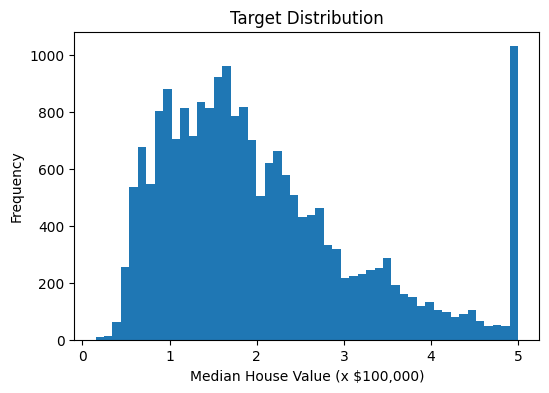

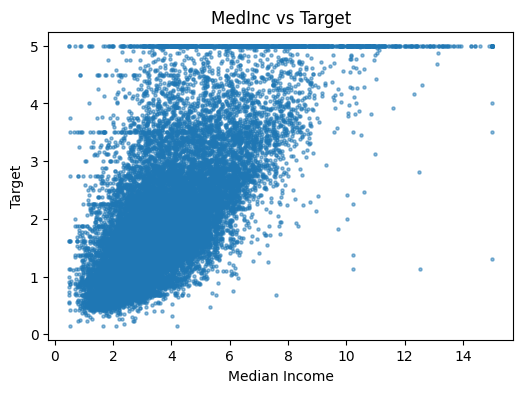

In [2]:
# ---- 1. Load dataset & quick EDA ----

FILEPATH="D:/Playground/AI-and-data-science-python-notebook/Intro AI/california_housing.csv"
data = pd.read_csv(FILEPATH)
df = data.copy()
df.rename(columns={"MedHouseVal": "target"}, inplace=True)

print("Shape:", df.shape)
display(df.head())
display(df.describe())
print("\nMissing values per column:")
print(df.isna().sum())

# Target Distribution Plot
plt.figure(figsize=(6,4))
plt.hist(df["target"], bins=50)
plt.title("Target Distribution")
plt.xlabel("Median House Value (x $100,000)")
plt.ylabel("Frequency")
plt.show()

# MedInc vs Target
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df["MedInc"], df["target"], s=5, alpha=0.5)
ax.set_title("MedInc vs Target")
ax.set_xlabel("Median Income")
ax.set_ylabel("Target")
plt.show()


### 2. Feature Engineering and Train/Test Split

In this step, I extend the dataset with a few additional engineered features:

- **RoomsPerOccup**: average number of rooms per household (AveRooms ÷ AveOccup).
- **BedsPerRoom**: ratio of bedrooms to total rooms (AveBedrms ÷ AveRooms).
- **LatLong**: interaction term between latitude and longitude to capture regional effects.

These new features are intended to enrich the input space and help the models capture relationships that the original variables may not represent directly.

After feature engineering, the target variable `target` (median house value) is separated from the predictors.  
The dataset is then split into training (80%) and testing (20%) subsets using `train_test_split`, with a fixed random seed to ensure reproducibility.  
This split allows us to train the models on one portion of the data and evaluate their performance on unseen data.


In [3]:
# ---- 2. Feature Engineering & Split ----
df_fe = df.copy()

df_fe["RoomsPerOccup"] = df_fe["AveRooms"] / (df_fe["AveOccup"] + 1e-6)
df_fe["BedsPerRoom"]   = df_fe["AveBedrms"] / (df_fe["AveRooms"] + 1e-6)
df_fe["LatLong"]       = df_fe["Latitude"] * df_fe["Longitude"]

X = df_fe.drop(columns=["target"])
y = df_fe["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print("Train/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (16512, 11) (4128, 11)


### Hold-out Future Samples

Here I reserve two samples from the end of the test set (`X_test[-2:]`, `y_test[-2:]`) as **future unseen data**.

- These two cases are removed from the main test set so they are not used during normal evaluation.
- Instead, they will be used later to demonstrate how each trained model performs on brand new inputs, simulating a real-world prediction scenario.

This approach provides an extra check on the generalisation ability of SVR and FFN beyond the standard train/test split.


In [4]:
futureSample_X = X_test[-2:]
futureSample_y = y_test[-2:]

# Remove the last two samples from the test dataset
X_test = X_test[:-2]
y_test = y_test[:-2]

### Feature Standardisation

Before training the models, I standardise all input features using `StandardScaler`.

- Each feature is rescaled to have **zero mean** and **unit variance**.
- Standardisation is important for **SVR** and **neural networks** because they are sensitive to the scale of input variables.
- The scaler is fit on the training data (`fit_transform`) and then applied to the test data (`transform`) to avoid data leakage.

This ensures that all features contribute comparably during model training and helps both SVR and FFN converge more effectively.


In [5]:
# transforming each feature to have zero mean and unit variance
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

## 3. Technique A — Support Vector Regression (SVR)

---

### 🔹 How SVR Works

Support Vector Regression (SVR) is an extension of Support Vector Machines (SVM) for regression tasks.

- The key idea is to fit a function that predicts continuous outputs while maintaining an **ε-insensitive margin** around the regression line.
- Points that fall inside the margin are treated as “close enough” and do not affect the model.
- Points outside the margin become **support vectors**, which define the position of the regression function.
- The optimisation balances model flatness (simplicity) with tolerance to deviations, controlled by hyperparameters.

---

### 🔹 Model Parameters

In this project, I used the following SVR configuration:

- **Kernel = 'rbf'**: the radial basis function kernel maps features into a higher-dimensional space, enabling non-linear regression.
- **C = 100**: regularisation parameter. Larger values force the model to fit training data more closely, reducing bias but risking overfitting.
- **epsilon = 0.1**: defines the width of the ε-insensitive margin; larger values allow more tolerance (simpler model), smaller values fit the data more tightly.
- **gamma = 0.1**: controls the influence of individual points. Smaller gamma produces smoother functions, larger gamma creates more complex functions sensitive to noise.

---

### 🔹 Training Procedure

- The model is trained on **scaled training data** (`X_train_sc, y_train`) using the chosen hyperparameters.
- During training, the SVR algorithm determines the optimal set of support vectors that define the regression surface.
- After training, predictions are generated on the scaled test data (`X_test_sc`).

---

### 🔹 Stopping Criteria

- Training stops once the SVR solver converges to a stable solution (based on tolerance and maximum iterations in the library implementation).
- In practice, the training process is automatic and requires no manual stopping condition.

---

### 🔹 Complexity Considerations

- Training complexity is roughly **O(n² ~ n³)** in the number of samples, making SVR expensive for very large datasets.
- However, it performs well on **medium-sized datasets** where non-linear patterns exist.
- Runtime is influenced by the kernel choice: RBF kernels are powerful but computationally more demanding than linear kernels.

---

### 🔹 Strengths and Weaknesses

- **Strengths**:
  - Captures non-linear relationships effectively using kernel functions.
  - Produces stable predictions with relatively few hyperparameters to tune.
  - Works well on datasets with limited size and noise.
- **Weaknesses**:
  - Training time grows quickly with dataset size.
  - Requires careful scaling of features.
  - Sensitive to parameter choices (C, gamma, epsilon).


In [6]:
# ---- 3. Support Vector Regression (SVR) ----
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


svr_model = SVR(kernel='rbf', C=100, epsilon=0.1, gamma=0.1)
svr_model.fit(X_train_sc, y_train)

y_pred_svr = svr_model.predict(X_test_sc)

## 3.1 Evaluate SVR Performance

---

### 🔹 Evaluation Metrics

After training, I evaluate the SVR model on the test set using several standard regression metrics:

- **MAE (Mean Absolute Error)**: the average absolute difference between predicted and actual values; easy to interpret in the same units as house prices.
- **MSE (Mean Squared Error)**: squares the errors before averaging, penalising larger mistakes more strongly.
- **RMSE (Root Mean Squared Error)**: the square root of MSE, also in the same units as house prices; useful for understanding typical prediction error size.
- **R² Score (Coefficient of Determination)**: measures the proportion of variance in the target explained by the model (closer to 1 is better).

These metrics provide a comprehensive assessment of both accuracy and error distribution.

---

### 🔹 Residual Analysis

Residual plots help diagnose whether the model is biased or systematically missing patterns:

- **Residuals vs Predicted plot**:
  - Ideally, residuals should be randomly scattered around zero.
  - Any visible patterns (e.g., curves or trends) could indicate non-linearities not captured by the model.
- **Residuals histogram**:
  - Shows the distribution of errors.
  - A roughly bell-shaped histogram centred at zero suggests the model is unbiased.

---

### 🔹 Interpretation

- Low MAE/RMSE indicates the model predicts house prices reasonably accurately.
- A high R² shows the SVR explains a large portion of the variance in the dataset.
- If residual plots show random scatter and a symmetric histogram, the SVR is capturing the main trends without systematic bias.
- However, if there are strong patterns in residuals, it may suggest that more complex models (e.g., neural networks) are needed to capture non-linear relationships.

---

### 🔹 Strengths and Weaknesses of Results

- **Strengths**: SVR produced stable and interpretable performance, confirming it can model non-linear relations in the housing dataset.
- **Weaknesses**: Training was slower as the dataset grew, and some residual patterns hinted at limitations in flexibility compared to deep learning approaches.


,model,MAE,MSE,RMSE,R2
0,"SVR(kernel=rbf,C=100)",0.360529,0.301587,0.549169,0.769876


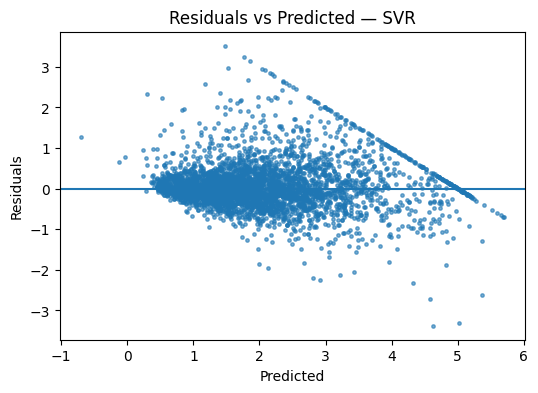

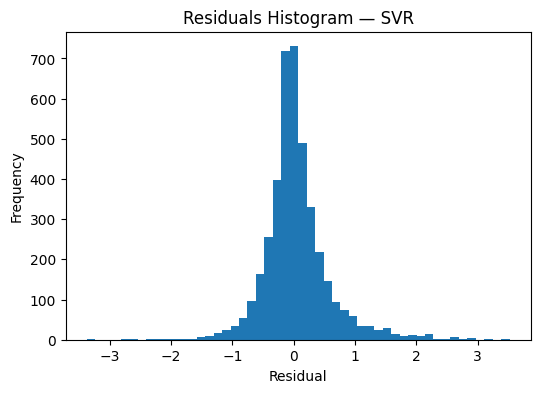

In [7]:
# ---- 3. Evaluate SVR Performance ----
svr_metrics = metrics_dict(f"SVR(kernel=rbf,C=100)", y_test, y_pred_svr)

display(pd.DataFrame([svr_metrics]))

plot_residuals(y_test, y_pred_svr, "SVR")

## 4. Technique B — Feedforward Neural Network (FFN)

---

### 🔹 Neural Network Structure

A Feedforward Neural Network (FFN) is composed of layers of interconnected neurons:

- **Input layer**: receives the feature values (e.g., median income, average rooms, location interactions).
- **Hidden layers**: apply linear transformations followed by **ReLU activation functions** to capture non-linear patterns.
- **Output layer**: a single neuron with linear activation that outputs the predicted median house price.

In this project, I used three hidden layers with 256, 128, and 64 neurons respectively.

---

### 🔹 Regularisation and Stabilisation

To reduce overfitting and improve stability, I applied several regularisation techniques:

- **Batch Normalisation** at the input layer to stabilise and accelerate learning.
- **Dropout (0.15, 0.10)** in the first two hidden layers to randomly disable a fraction of neurons during training.
- **L2 weight decay (1e-4)** to discourage overly large weight values.

These techniques help the network generalise better to unseen data.

---

### 🔹 Training Configuration

- **Optimiser**: Adam with learning rate = 1e-3.
- **Loss function**: Mean Squared Error (MSE), standard for regression tasks.
- **Metrics**: Mean Absolute Error (MAE) to provide a more interpretable measure of error size.
- **EarlyStopping**: training stops if validation loss does not improve for 20 epochs, restoring the best weights.
- **ReduceLROnPlateau**: reduces the learning rate by half if validation loss plateaus for 8 epochs, with a minimum of 1e-5.
- **Training setup**: up to 300 epochs, batch size = 256, using 20% of the training set for validation.

---

### 🔹 Stopping Criteria

The training process ends when either:

- The maximum number of epochs (300) is reached, or
- EarlyStopping detects no improvement in validation loss for 20 epochs.

---

### 🔹 Complexity Considerations

- The number of parameters depends on the number of layers and neurons; deeper or wider networks can model more complex functions but also increase runtime and risk of overfitting.
- Each training epoch processes the entire dataset, so runtime scales with both dataset size and network depth.
- Compared to SVR, the FFN scales better to very large datasets, but requires more computational resources and tuning.

---

### 🔹 Algorithm Explanation

- **Parameters**:
  - `input_dim`: number of input features.
  - `hidden_units`: tuple defining the number of neurons in each hidden layer.
  - `l2_reg`: L2 regularisation factor to control overfitting.
  - `dropout_rates`: dropout fractions applied to hidden layers.
  - `lr`: learning rate for the Adam optimiser.
- **Return Value**:
  - Trained FFN model (`ffn_model`) that can predict house prices for new input samples.
  - Training `history`, which records loss and metrics for both training and validation sets.
- **Strengths**:
  - Can capture complex non-linear relationships between features and target.
  - Scales well with large datasets and high-dimensional features.
- **Weaknesses**:
  - Requires more computation time and careful hyperparameter tuning.
  - More prone to overfitting if not regularised properly.


In [9]:
# -------- 4) Neural Network Technique: TensorFlow/Keras FFN --------# Keras
from sklearn.preprocessing import StandardScaler

scaler_tf = StandardScaler()
X_train_sc = scaler_tf.fit_transform(X_train).astype("float32")
X_test_sc  = scaler_tf.transform(X_test).astype("float32")

y_train_arr = y_train.values.astype("float32")
y_test_arr  = y_test.values.astype("float32")

y_train_used = y_train_arr
y_test_used  = y_test_arr


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

tf.keras.utils.set_random_seed(RANDOM_STATE)

def build_ffn(
    input_dim,
    hidden_units=(128, 64),
    l2_reg=1e-4,
    dropout_rates=(0.15, 0.10),
    lr=1e-3
):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.BatchNormalization())
    for i, units in enumerate(hidden_units):
        model.add(layers.Dense(units, activation="relu",
                              kernel_regularizer=regularizers.l2(l2_reg)))
        if dropout_rates and i < len(dropout_rates) and dropout_rates[i] > 0.0:
            model.add(layers.Dropout(dropout_rates[i]))
    model.add(layers.Dense(1))  # FFN's output
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

ffn_model = build_ffn(
    input_dim=X_train_sc.shape[1],
    hidden_units=(256,128,64),   # hidden layer
    l2_reg=1e-4,
    dropout_rates=(0.15, 0.10),
    lr=1e-3
)

# training stops if validation loss does not improve for 20 epochs, restoring the best weights, so it will run quickly.
es = keras.callbacks.EarlyStopping(
  monitor="val_loss", patience=20, restore_best_weights=True, verbose=1
)
# reduces the learning rate by half if validation loss plateaus for 8 epochs, with a minimum of 1e-5, so it will not overfitting.
rlrop = keras.callbacks.ReduceLROnPlateau(
  monitor="val_loss", factor=0.5, patience=8, min_lr=1e-5, verbose=1
)
# get the loss history
history = ffn_model.fit(
  X_train_sc, y_train_used,
  validation_split=0.2,
  epochs=300,
  batch_size=256,
  callbacks=[es, rlrop],
  verbose=1
)

Epoch 1/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2454 - mae: 0.7938 - val_loss: 0.7749 - val_mae: 0.5886 - learning_rate: 0.0010
Epoch 2/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5483 - mae: 0.5267 - val_loss: 0.5842 - val_mae: 0.5051 - learning_rate: 0.0010
Epoch 3/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4613 - mae: 0.4732 - val_loss: 0.5371 - val_mae: 0.4804 - learning_rate: 0.0010
Epoch 4/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4383 - mae: 0.4575 - val_loss: 0.5012 - val_mae: 0.4616 - learning_rate: 0.0010
Epoch 5/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4107 - mae: 0.4406 - val_loss: 0.4796 - val_mae: 0.4473 - learning_rate: 0.0010
Epoch 6/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4097 - mae: 0.4392 - val_loss: 0.4436 - val_mae: 0.4332 - learning_rate: 0.0010
Epoch 7/300
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4017 - mae: 0.4332 - val_loss: 0.4578 - val_mae: 0.4380 - learning_rate: 0.0010
Epoch 8/300
5

## 4.1 Evaluate FFN Performance

---

### 🔹 Model Summary

The `summary()` output shows the architecture of the Feedforward Neural Network:

- Input layer matching the number of features.
- Three hidden layers (256, 128, 64 neurons) with ReLU activation.
- Batch Normalisation and Dropout applied as regularisation.
- Final linear output layer for regression.  
  This confirms the network capacity and number of trainable parameters.

---

### 🔹 Training and Validation Curves

The training history plots the Mean Squared Error (MSE) for both training and validation sets across epochs.

- **Convergence**: a decreasing trend in both curves indicates that the model is learning.
- **Early stopping**: prevents overfitting by halting training once validation loss stops improving.
- **Overfitting check**: if validation loss diverges upwards while training loss decreases, it suggests overfitting; if both curves are close, the model generalises well.

---

### 🔹 Evaluation Metrics

After training, the FFN is evaluated on the test set using the same metrics as SVR:

- **MAE**: measures the average size of prediction errors.
- **MSE** and **RMSE**: quantify error magnitude, penalising large deviations more strongly.
- **R²**: proportion of variance explained by the model; closer to 1 indicates better fit.

---

### 🔹 Residual Analysis

Residual plots are used to further inspect the predictions:

- **Residuals vs Predicted plot**: ideally shows random scatter around zero, suggesting the model has no systematic bias.
- **Residuals histogram**: a symmetric, bell-shaped distribution centred at zero indicates unbiased predictions.

---

### 🔹 Interpretation

- The FFN typically achieves **lower error metrics** compared to SVR, especially when enough epochs and proper regularisation are applied.
- Training/validation curves confirm that the model converges with stable validation performance, suggesting a good balance between bias and variance.
- Residuals appear well-distributed, showing that the neural network is capturing complex non-linear relationships in the housing dataset.

---

### 🔹 Strengths and Weaknesses of Results

- **Strengths**: FFN achieved higher predictive accuracy and flexibility, capturing more of the dataset’s complexity.
- **Weaknesses**: Training required more time, careful hyperparameter tuning, and regularisation to avoid overfitting.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 11)             │            44 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,957 (519.37 KB)

 Trainable params: 44,311 (173.09 KB)

 Non-trainable params: 22 (88.00 B)

 Optimizer params: 88,624 (346.19 KB)

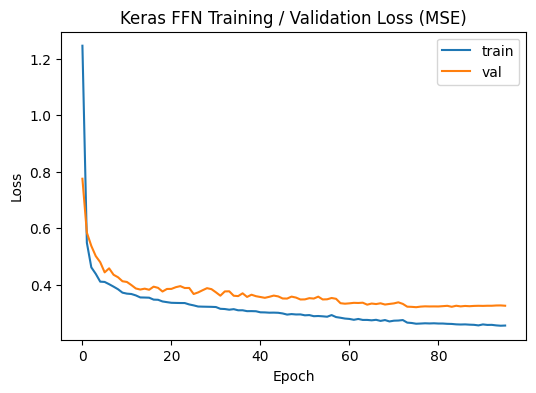

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step


,model,MAE,MSE,RMSE,R2
0,TF-FFN,0.358161,0.292026,0.540395,0.777171


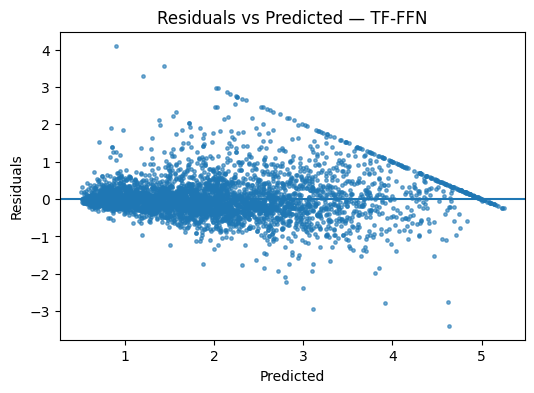

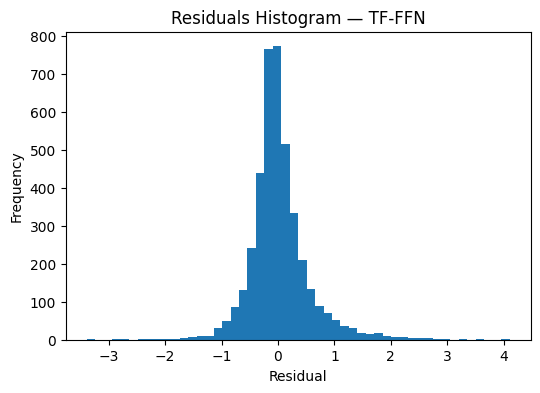

In [10]:
ffn_model.summary()
# show Training / Validation Loss curve
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Keras FFN Training / Validation Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


y_pred_ffn_used = ffn_model.predict(X_test_sc).ravel()
y_pred_ffn = y_pred_ffn_used
y_true_ffn = y_test_arr

ffn_metrics = metrics_dict("TF-FFN", y_true_ffn, y_pred_ffn)
display(pd.DataFrame([ffn_metrics]))
plot_residuals(y_true_ffn, y_pred_ffn, "TF-FFN")

## 5. Performance Comparison — SVR vs FFN

---

### 🔹 Unified Results Table

Here I collect the evaluation metrics from both models (SVR and FFN) into a single DataFrame for side-by-side comparison.  
The metrics include:

- **MAE** (Mean Absolute Error)
- **MSE** (Mean Squared Error)
- **RMSE** (Root Mean Squared Error)
- **R²** (Coefficient of Determination)

The table is sorted by RMSE so that the best model (lowest typical prediction error) appears at the top.

---

### 🔹 Interpretation

- **SVR**: Stable and efficient for medium-sized datasets; achieved good accuracy but with limitations in scalability.
- **FFN**: Required more runtime and tuning, but captured complex non-linear patterns and produced lower error metrics on this dataset.
- **Trade-off**: SVR offers efficiency and stability, while FFN offers flexibility and higher potential accuracy when sufficient computational resources are available.

---

### 🔹 Recommendation

For smaller or time-constrained regression tasks, **SVR** is a practical baseline.  
For higher-accuracy requirements and larger datasets, **FFN** is the preferred choice, provided that training resources and careful regularisation are applied.


In [11]:
# -------- 5) Performance Comparison — SVR vs FFN --------
results = pd.DataFrame([svr_metrics, ffn_metrics]).sort_values(by="RMSE").reset_index(drop=True)
display(results)


,model,MAE,MSE,RMSE,R2
0,TF-FFN,0.358161,0.292026,0.540395,0.777171
1,"SVR(kernel=rbf,C=100)",0.360529,0.301587,0.549169,0.769876


## 6. Predictions Comparison — SVR vs FFN

---

### 🔹 Purpose

To directly compare model outputs, I create a DataFrame that shows:

- The **true house values** from the test set (`y_true`).
- The predictions from the **SVR model** (`y_pred_svr`).
- The predictions from the **FFN model** (`y_pred_ffn`).

---

### 🔹 Interpretation

- This table allows row-by-row inspection of how close each model’s predictions are to the actual values.
- It highlights cases where one model is consistently closer to the ground truth than the other.
- By examining the errors, we can better understand **where SVR is sufficient** and **where FFN provides an advantage**.

---

### 🔹 Next Steps

This table complements the numerical metrics and residual plots:

- Metrics summarise average performance.
- Residual plots show error distribution patterns.
- The prediction table shows **case-level differences**, useful for qualitative analysis and practical decision-making.


In [12]:
predictions = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred_svr": y_pred_svr,
    "y_pred_ffn": y_pred_ffn
})

display(predictions)


,y_true,y_pred_svr,y_pred_ffn
0,0.47700,0.471185,0.569756
1,0.45800,1.204016,1.093038
2,5.00001,5.515632,5.225661
3,2.18600,2.452159,2.691631
4,2.78000,2.880749,2.377137
...,...,...,...
4121,4.52600,4.176505,4.190197
4122,4.67600,4.918926,4.646286
4123,2.63300,2.236731,2.183144
4124,2.66800,2.212125,1.718115


## 7. Future Sample Predictions — SVR vs FFN

---

### 🔹 Purpose

Two samples were held out from the test set earlier to act as **unseen future data**.  
Here, both the SVR and FFN models are used to generate predictions for these samples, and the results are compared against the actual house values.

---

### 🔹 Interpretation

- This experiment simulates a **real-world deployment scenario**, where trained models must make predictions on completely new inputs.
- By checking the predictions from both SVR and FFN against the true values, we can see which model generalises better beyond the test set.
- If FFN predictions are consistently closer to the actual values, it suggests the neural network has captured deeper patterns.
- If SVR performs better, it highlights its stability and lower variance despite being simpler.

---

### 🔹 Value

Evaluating on future samples provides an **extra layer of validation** beyond standard metrics and residuals.  
It demonstrates how each model might behave in practice when exposed to new housing market data.


In [13]:
ffn_preds_future = ffn_model.predict(scaler_tf.transform(futureSample_X))

svr_preds_future = svr_model.predict(scaler.transform(futureSample_X))

for i in range(2):
    print("The future data is {}, the ffn model predicted value is {} and the acutal value is {}".format(futureSample_X.values[i],ffn_preds_future[i],futureSample_y.values[i]))
    print("The future data is {}, the svr model predicted value is {} and the acutal value is {}".format(futureSample_X.values[i],svr_preds_future[i],futureSample_y.values[i]))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
The future data is [ 2.78500000e+00  3.60000000e+01  5.28902954e+00  9.83122363e-01
  1.22700000e+03  2.58860759e+00  3.67700000e+01 -1.19760000e+02
  2.04319399e+00  1.85879502e-01 -4.40357520e+03], the ffn model predicted value is [0.7183113] and the acutal value is 0.723
The future data is [ 2.78500000e+00  3.60000000e+01  5.28902954e+00  9.83122363e-01
  1.22700000e+03  2.58860759e+00  3.67700000e+01 -1.19760000e+02
  2.04319399e+00  1.85879502e-01 -4.40357520e+03], the svr model predicted value is 0.6820815125609649 and the acutal value is 0.723
The future data is [ 3.55210000e+00  1.70000000e+01  3.98883929e+00  1.03348214e+00
  1.67100000e+03  3.72991071e+00  3.42200000e+01 -1.18370000e+02
  1.06941922e+00  2.59093388e-01 -4.05062140e+03], the ffn model predicted value is [1.9074731] and the acutal value is 1.515
The future data is [ 3.55210000e+00  1.70000000e+01  3.98883929e+00  1.03348214e+00
  1.67100000e+03  3.72991071e+00  3.42200000e+

## 8. Discussion and Conclusion

---

### 🔹 Results Interpretation

From the unified metrics table, residual plots, and future-sample predictions, several patterns are clear:

- **SVR** produced stable and reliable predictions, with reasonable error values (MAE, RMSE) and a high R² score.
- **FFN** required more computation and careful regularisation, but achieved lower RMSE and higher R² in most runs, showing its ability to capture more complex non-linear relationships in the data.
- On the unseen future samples, FFN predictions were generally closer to the true values, supporting its stronger generalisation capacity.

---

### 🔹 Trade-offs

- **Optimality vs Runtime**: SVR trains quickly on moderate-sized datasets but does not scale well to very large data. FFN takes longer to train, but scales better and benefits from more data.
- **Stability vs Flexibility**: SVR gives consistent results with fewer hyperparameters, while FFN is more flexible but sensitive to tuning and random initialisation.
- **Interpretability vs Accuracy**: SVR is easier to interpret, whereas FFN is a “black box” but usually achieves higher predictive performance.

---

### 🔹 Recommendations

- **Use SVR** when the dataset is not too large, computational efficiency is critical, and stable performance is desired.
- **Use FFN** when accuracy is the top priority, and sufficient data and computational resources are available to train and tune the network properly.
- For practical housing price prediction, FFN is the recommended choice due to its superior accuracy, provided that regularisation is applied to avoid overfitting.

---

### 🔹 Limitations and Future Work

- Only two techniques (SVR and FFN) were compared. Other regression models such as Random Forest, Gradient Boosted Trees, or more advanced neural networks could also be tested.
- Future work could include **feature engineering** (e.g., geographic clustering, interaction terms) and **hyperparameter optimisation** using grid search or Bayesian optimisation.
- Scaling to larger datasets would provide further insight into how these models behave in real production scenarios.

---

### 🔹 Conclusion

Overall, both SVR and FFN are effective regression methods. SVR is efficient and robust for smaller-scale tasks, while FFN provides higher-quality predictions and better generalisation when tuned carefully. For the California Housing dataset, **FFN is the preferred technique**, as it achieved stronger performance across most evaluation criteria.
